In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import lib

In [3]:
train_data = pd.read_csv('../data/house_price_prediction/train.csv')
test_data = pd.read_csv('../data/house_price_prediction/test.csv')

In [5]:
print(train_data.shape)
print(test_data.shape)
# check first 4 rows with selected columns
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [6]:
# delete the first column 'Id'
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
# standardize the data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# fill the missing values with 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
# convert the categorical data to dummy variables (include na, one-hot)
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [10]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
# use linear model as baseline
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$

In [15]:
def log_rmse(net, features, labels):
    # transform to log space
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = lib.load_array((train_features, train_labels), batch_size)
    # use Adam optimizer
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [19]:
# k-fold cross validation from scratch
# can also refer to scikit-learn API
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            lib.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'Fold {i + 1}，train log rmse: {float(train_ls[-1]):f}, '
              f'val log rmse: {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

Fold 1，train log rmse: 0.170883, val log rmse: 0.156487
Fold 2，train log rmse: 0.162293, val log rmse: 0.189918
Fold 3，train log rmse: 0.163495, val log rmse: 0.167963
Fold 4，train log rmse: 0.168047, val log rmse: 0.154596
Fold 5，train log rmse: 0.163214, val log rmse: 0.183158
5-fold validation: avg train log rmse: 0.165586, avg val log rmse: 0.170424


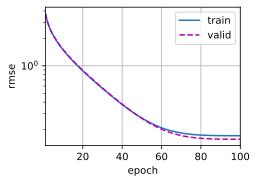

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg val log rmse: {float(valid_l):f}')

In [21]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    lib.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse：{float(train_ls[-1]):f}')
    # apply the network to the test set
    preds = net(test_features).detach().numpy()
    # reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../output/submission.csv', index=False)

train log rmse：0.162656


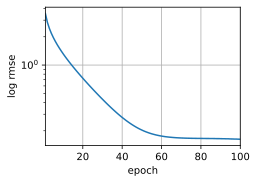

In [22]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)